In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(3011)

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Fix D_r, W_in, B_in；
Fix [0, 2pi]；
change dt and N；
dt * N = 2pi

In [2]:
#fixing parameter D_r, W, B, T
D_r = 500

def pickw(w=0.005, D_r = 500, D = 2):
    W_in = np.random.uniform(-w, w, (D_r, D))
    return W_in

def pickb(b=4, D_r = 500):
    B_in = np.random.uniform(-b, b, (D_r,1))
    return B_in

W = pickw(w=0.005)
B = pickb(b=4)

t0 = 0
t1 = 2*np.pi

In [3]:
#Algorithm
def find_approximation(system: callable, t0: float, t1: float,
                       N=100, D_r=D_r, w=W, b=B, beta=1E-5):
    U: np.ndarray = system(np.linspace(t0, t1, N+1))
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = w
    b_in = b
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    U_pred = np.atleast_2d(U_hat[:, -1]).T
    for _ in range(N):
        u_n = U_pred[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat
    return U, U_hat, U_pred

In [4]:
#linear system: circle
def linear_system(t, c1=1, c2=1):

    """
    Return values for the system

    dx/dt = (0   1) (x)
    dy/dt   (-1  0) (y)
    """
    x = c1 * sin(t) - c2 * cos(t)
    y = c1 * cos(t) + c2 * sin(t)
    return np.array([x, y])

In [5]:
#function to find 2-norm
def find_norm2(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm2 = 0
    for n in range(N_0):
        norm2 += (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
    return np.sqrt(norm2) / N_0
find_norm2(linear_system,200)

0.0006559005550581431

In [6]:
#function to find infinite norm
def find_norminf(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm = []
    for n in range(N_0):
        norm.append(np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))
    return max(norm)
find_norminf(linear_system,100)

0.015739766899768016

Text(0.5, 1.0, '2-norm / N')

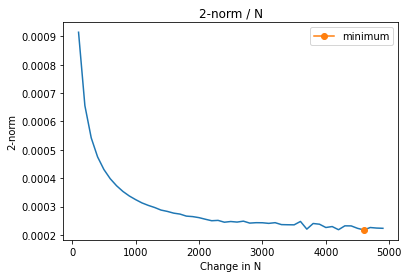

In [7]:
#plot for 2-norm
N = np.arange(100, 5000, 100)
dt = t1 / N
norm2 = []
for n in N:
    norm2.append(find_norm2(linear_system, n))
    
i2 = np.argmin(norm2)

plt.plot(N, norm2)
plt.plot(N[i2], norm2[i2], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N")

Text(0.5, 1.0, 'infinite norm / N')

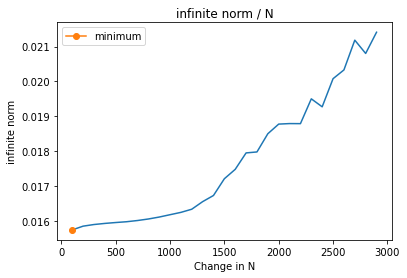

In [8]:
#plot for inf norm
N = np.arange(100, 3000, 100)
dt = t1 / N
norminf = []
for n in N:
    norminf.append(find_norminf(linear_system, n))

i3 = np.argmin(norminf)

plt.plot(N, norminf)
plt.plot(N[i3], norminf[i3], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("infinite norm")
plt.title("infinite norm / N")

Text(0.5, 1.0, '2-norm / N with 10 random W&B')

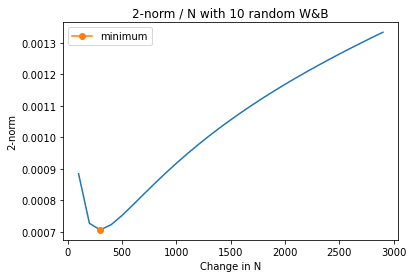

In [9]:
#plot for 2-norm for 10 different W/B realisations
N = np.arange(100, 3000, 100)
dt = t1 / N
it = 10
mean2 = np.zeros(len(N))
for w in range(it):
    norm2 = []
    W_i = pickw(w=0.005)
    B_i = pickb(b=4)
    for n in N:
        norm2.append(find_norm2(linear_system, n, w_0 = W_i, b_0 = B_i))
    mean2 = mean2 + np.array(norm2)
mean2 = mean2/it

i4 = np.argmin(mean2)

plt.plot(N, mean2)
plt.plot(N[i4], mean2[i4], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N with 10 random W&B")

Text(0.5, 1.0, 'max(ϵ) / N with 10 random W&B')

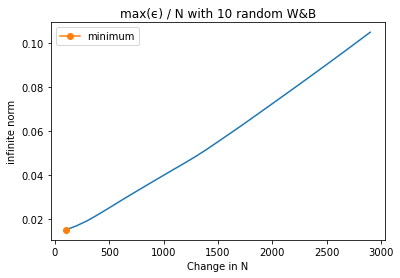

In [10]:
#plot for infinite norm for 10 different W/B realisations
N = np.arange(100, 3000, 100)
dt = t1 / N
it = 10
meaninf = np.zeros(len(N))
for w in range(it):
    norminf = []
    W_i = pickw(w=0.005)
    B_i = pickb(b=4)
    for n in N:
        norminf.append(find_norminf(linear_system, n, w_0 = W_i, b_0 = B_i))
    meaninf = meaninf + np.array(norminf)
meaninf = meaninf/it

i5 = np.argmin(meaninf)

plt.plot(N, meaninf)
plt.plot(N[i5], meaninf[i5], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("infinite norm")
plt.title("max(ϵ) / N with 10 random W&B")